In [15]:
import numpy as np
import scipy.io.wavfile as wavfile

import matplotlib.pyplot as plt

from pydub import AudioSegment
from pydub.silence import split_on_silence

from sklearn.decomposition import FastICA, PCA

## Util functions

In [16]:
def sound_to_features_matrix(sound):
    nb_chunk = len(sound)
    nb_freq = len(sound[0])
    X = np.zeros((nb_chunk, nb_freq))
    for c in range(0, nb_chunk):
        X[c] = np.array(sound[c])
    return X

def save_samples(S, rate):
    nb_chunk = S.shape[0]
    try:
        for i in range(0, nb_chunk):
            wavfile.write('generated_{}.wav'.format(i), rate, S[i])
    except:
        print('Failed to write samples to disk.')

# Reverse music sampling

Goal of this project: find the samples used to generate a music using ICA.

Through this TP, I will try several approach and see which one give the best results.

## 1. Load the data
Take a look at scipy.io.wavfile.read

In [17]:
def load_sounds(files):
    sounds = []
    for sound_path in files:
        
        obj = AudioSegment.from_wav(sound_path)
        sound_object = {
            "object": obj,
            "data": obj.get_array_of_samples(),
            "rate": obj.frame_rate
        }    
        
        sounds.append(sound_object)
        
    return sounds

In [18]:
sound_files = [ "parade.wav" ]

sounds = load_sounds(sound_files)
nb_sound = len(sounds)

print("Number of sounds: {}".format(nb_sound))

Number of sounds: 1


## 2. Sample the data
You have to cut the music into small chunks. Several strategies are possible for this task, find the best one!

In [67]:
def split_with_pydub(sound, min_silence=1000):
    split = split_on_silence(sound, min_silence_len=min_silence)
    chunks = []
    for i in range(0, len(split)):
        chunks.append(split[i].get_array_of_samples())

    return chunks

In [68]:
def split_uniformly(sound):
    return

# splitted_sounds = split_with_pydub(sounds)

In [96]:
def pad_chunk(sound, split_type="Left"):
    # Length of the greatest chunk ever
    max_len = 0
    
    """
        Finds the largest chunk, this is used o add padding
        to all other chunks.
        
        This loop will also convert every chunk to a numpy array,
        in order to simplify their modification.
    """ 
    nb_chunks = len(sound)
    for c in range(0, nb_chunks):
        chunk_len = len(sound[c])
        max_len = chunk_len if chunk_len > max_len else max_len
    
    """
        We can now pad all the chunks with this padding.
    """
    
    chunks = []
    for c in range(0, nb_chunks):
        a = sound[c].tolist()
        chunk_size = len(a)
        zeros = np.zeros(max_len)
        if split_type == "Left":
            start = max_len - chunk_size
            zeros[start:] = a
        elif split_type == "Center":
            start = (int)(max_len * 0.5) - (int)(chunk_size * 0.5)
            zeros[start:start + chunk_size] = a
        elif split_type == "Right":
            zeros[0:chunk_size] = a
            
        chunks.append(zeros)
    
    return chunks

In [97]:
# print("Number of chunks example: {}".format(len(splitted_sounds[0])))

In [91]:
processed_sounds = process(splitted_sounds, "Right")


## 3. Run an ICA
Run an ICA on your samples and listen to the result. Does it make sense?

In [92]:
def ica(sound, nb_comp=None, print_data=True):
    
    X = sound_to_features_matrix(processed_sounds[0])
    nb_chunks = X.shape[0]
    if not(nb_comp is None):
        nb_chunks = nb_comp
    
    ica = FastICA(n_components=nb_chunks)
    S = ica.fit_transform(X.T)
    S = S.T
    
    if print_data:
        plt.title("{} samples unmixed".format(nb_chunks))
        for i in range(0, nb_chunks):
            plt.plot(S[i], label="sample {}".format(i), alpha=0.5)
        plt.legend()
        plt.show()
    
    return S

### Function to compare different techniques

In [93]:
def run(sound_object, data):
    sound_obj = sound_object["object"]
    sound = sound_object["data"]
    rate = sound_object["rate"]
    
    run_type = "Uniform" if not("run_type" in data) else data["run_type"]
    
    nb_comp = len(sound) if not("nb_comp" in data) else data["nb_comp"]
    
    # Displays information about the current run.
    print("Number of desired components: {}".format(nb_comp))
    
    if run_type == "Silent":
        pad_type = "Left" if not("pad_type" in data) else data["pad_type"]
        chunk = split_with_pydub(sound_obj)
        chunk = pad_chunk(chunk, pad_type)
        
        plot = True if not("plot" in data) else data["plot"]
        save = False if not("save" in data) else data["save"]
        
        S = ica(sound, nb_comp, plot)
        if save:
            save_samples(S, rate)
        

### Test 1: Split on silence

We have a problem here, if we cut the sample in a non-uniform way, we will obtain samples with different size, which is a problem for the ICA.

We will try to add padding to see if it helps.

### Chunks splitted on silence

Number of desired components: 5
acdadada
acdadada
acdadada
acdadada
acdadada
acdadada
acdadada
acdadada
acdadada
acdadada
acdadada
acdadada
acdadada
acdadada
acdadada
acdadada
acdadada
acdadada
acdadada
acdadada
acdadada
acdadada
acdadada


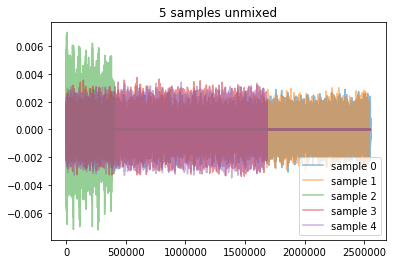

In [98]:
#S = ica(processed_sounds[0], 6, True)
data = {
    "plot": True,
    "run_type": "Silent",
    "pad_type": "Center",
    "save": True,
    "nb_comp": 5
}
run(sounds[0], data)

## 4. Validate your results
Find a metric to evaluate your method and try to improve it.